In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [83]:
file = 'global_data_4_1'
time_bins = np.arange(0,24,float(file.split('_')[-1]))
H_bins = np.arange(90,130,float(file.split('_')[-2]))

shape = len(time_bins) * len(H_bins)

file_path = f'../../Output/{file}.csv'

In [84]:
data_df = pd.read_csv(file_path,low_memory=False)
Ne_EXP = np.array(data_df['EXP Density']).reshape(-1,shape)
dNe_EXP =  np.array(data_df['EXP Density Error']).reshape(-1,shape)
Ne_WACCM = np.array(data_df['WACCM Density']).reshape(-1,shape)
mag_EXP = np.array(data_df['EXP Magnitude']).reshape(-1,shape)
mag_WACCM = np.array(data_df['WACCM Magnitude']).reshape(-1,shape)
height = np.array(data_df['Height']).reshape(-1,shape)
time = np.array(data_df['Hours']).reshape(-1,shape)
Date = np.array(data_df['Date']).reshape(-1,shape)[:,0]

Ne_EXP_gradient_time = mag_EXP.reshape(-1, len(H_bins), len(time_bins))
zero_gradient_mask = Ne_EXP_gradient_time == 0
Ne_EXP_gradient_time = (Ne_EXP_gradient_time[:,:,1:] -  Ne_EXP_gradient_time[:,:,:-1])/time_bins[1]
Ne_EXP_gradient_time = np.concatenate((Ne_EXP_gradient_time, Ne_EXP_gradient_time[:,:,-1:]), axis=2)
Ne_EXP_gradient_time[np.roll(zero_gradient_mask,1,axis=1)] = Ne_EXP_gradient_time[np.roll(zero_gradient_mask,2,axis=1)]
Ne_EXP_gradient_time[np.roll(zero_gradient_mask,-1,axis=1)] = Ne_EXP_gradient_time[np.roll(zero_gradient_mask,-2,axis=1)]
Ne_EXP_gradient_time = Ne_EXP_gradient_time.reshape(-1,shape)

zero_mask = Ne_EXP != 0
Ne_EXP[~zero_mask] = 1

Ne_diff = np.abs(Ne_EXP - Ne_WACCM)
error_mask = Ne_diff < dNe_EXP

Ne_EXP[error_mask] = 1
dNe_EXP[error_mask] = 0

dNe_fac = dNe_EXP/Ne_EXP
factor_error_mask = dNe_fac > 2

Ne_EXP[factor_error_mask] = 1

zero_mask = Ne_EXP != 0
Ne_EXP[~zero_mask] = 1

value_mask = Ne_EXP != 1

abs_diff = np.abs(Ne_WACCM - Ne_EXP).astype(float)/Ne_EXP
norm_diff = (Ne_WACCM - Ne_EXP) / (Ne_WACCM + Ne_EXP)

index = 34
index = np.min([index, len(Ne_EXP)-1])
date = Date[index]

count = np.sum(Ne_EXP != 0, axis=0)
abs_diff_tot = np.abs(Ne_WACCM - Ne_EXP)
norm_diff = (Ne_EXP - Ne_WACCM) / (Ne_WACCM + Ne_EXP)
err_mag_tot = np.nansum(abs_diff_tot, axis=0)/np.sum(Ne_EXP,axis=0)

zero = Ne_EXP == 0
abs_diff_tot[zero] = 1
good = np.sum(abs_diff_tot < dNe_EXP, axis = 0)/count
abs_diff_tot[zero] = 0

norm_diff_tot = np.nansum(norm_diff, axis=0)
norm_diff_tot = norm_diff_tot/np.max(np.abs(norm_diff_tot))
count = count/len(Ne_EXP)

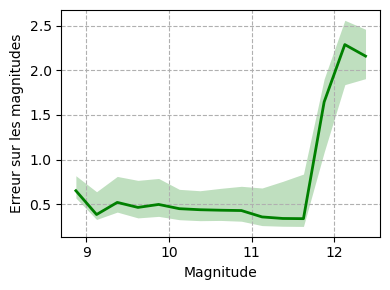

In [102]:
plt.figure(figsize=(4, 3))

mag_bins = np.linspace(8,13,21)

Ne_diff_flat = np.abs(mag_EXP - mag_WACCM)[value_mask]
mag_flat = mag_EXP[value_mask]

mean_list = []
less_sigma_list = []
more_sigma_list = []
mean_count_list = []


for mag_bin in mag_bins:
    mag_mask = np.abs(mag_flat - mag_bin) <= (mag_bins[1] - mag_bins[0])/2
    if len(Ne_diff_flat[mag_mask]) == 0:
        mean_value = 0
        less_sigma_value = 0
        more_sigma_value = 0
    else:
        mean_value = np.mean(Ne_diff_flat[mag_mask])
        less_sigma_value = np.std(np.concatenate((Ne_diff_flat[mag_mask][Ne_diff_flat[mag_mask]<mean_value], [mean_value])))
        more_sigma_value = np.std(np.concatenate((Ne_diff_flat[mag_mask][Ne_diff_flat[mag_mask]>mean_value], [mean_value])))
    mean_list.append(mean_value)
    less_sigma_list.append(less_sigma_value)
    more_sigma_list.append(more_sigma_value)
    mean_count_list.append(len(Ne_diff_flat[mag_mask]))

mean = np.array(mean_list)
less_sigma = np.array(less_sigma_list)
more_sigma = np.array(more_sigma_list)
mean_count = np.array(mean_count_list)

x = np.array(mag_bins)

mean_mask = mean_count > 1

mean = mean[mean_mask]
less_sigma = less_sigma[mean_mask]
more_sigma = more_sigma[mean_mask]
x = x[mean_mask]
mean_count = mean_count[mean_mask]

plt.fill_between(x + (mag_bins[1] - mag_bins[0])/2, mean-less_sigma, mean+more_sigma, color = 'green', alpha=.25, linewidth=0)
plt.plot(x + (mag_bins[1] - mag_bins[0])/2, mean, 'green', linewidth=2)
plt.grid(linestyle='--')

plt.xlabel(r'Magnitude')
plt.ylabel(r'Erreur sur les magnitudes')

plt.tight_layout()
plt.show()

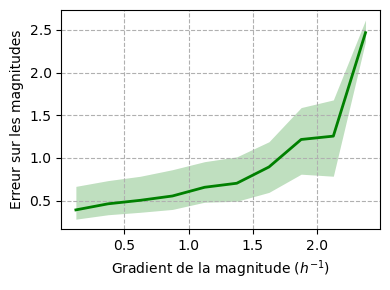

In [101]:
plt.figure(figsize=(4, 3))

gradient_bins = np.linspace(0,5,21)

Ne_diff_flat = np.abs(mag_EXP - mag_WACCM)[value_mask]
gradient_flat = np.abs(Ne_EXP_gradient_time[value_mask])

mean_list = []
less_sigma_list = []
more_sigma_list = []
mean_count_list = []

for gradient_bin in gradient_bins:
    gradient_mask = np.abs(gradient_flat - gradient_bin) <= (gradient_bins[1] - gradient_bins[0])/2
    if len(Ne_diff_flat[gradient_mask]) == 0:
        mean_value = 0
        less_sigma_value = 0
        more_sigma_value = 0
    else:
        mean_value = np.mean(Ne_diff_flat[gradient_mask])
        less_sigma_value = np.std(np.concatenate((Ne_diff_flat[gradient_mask][Ne_diff_flat[gradient_mask]<mean_value], [mean_value])))
        more_sigma_value = np.std(np.concatenate((Ne_diff_flat[gradient_mask][Ne_diff_flat[gradient_mask]>mean_value], [mean_value])))
    mean_list.append(mean_value)
    less_sigma_list.append(less_sigma_value)
    more_sigma_list.append(more_sigma_value)
    mean_count_list.append(len(Ne_diff_flat[gradient_mask]))

mean = np.array(mean_list)
less_sigma = np.array(less_sigma_list)
more_sigma = np.array(more_sigma_list)
mean_count = np.array(mean_count_list)

x = np.array(gradient_bins)

mean_mask = mean_count > 1

mean = mean[mean_mask]
less_sigma = less_sigma[mean_mask]
more_sigma = more_sigma[mean_mask]
x = x[mean_mask]
mean_count = mean_count[mean_mask]

plt.fill_between(x + (gradient_bins[1] - gradient_bins[0])/2, mean-less_sigma, mean+more_sigma, color = 'green', alpha=.25, linewidth=0)
plt.plot(x + (gradient_bins[1] - gradient_bins[0])/2, mean, 'green', linewidth=2)
plt.grid(linestyle='--')

plt.xlabel(r'Gradient de la magnitude ($h^{-1})$')

plt.ylabel('Erreur sur les magnitudes')

plt.tight_layout()
plt.show()

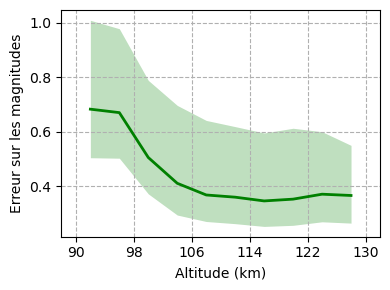

In [87]:
plt.figure(figsize=(4, 3))

Ne_diff_flat = np.abs(mag_EXP - mag_WACCM)[value_mask]
height_flat = height[value_mask]

mean_list = []
less_sigma_list = []
more_sigma_list = []


for H_bin in H_bins:
    h_mask = height_flat == H_bin
    mean_value = np.mean(Ne_diff_flat[h_mask])
    mean_list.append(mean_value)
    less_sigma_list.append(np.std(Ne_diff_flat[h_mask][Ne_diff_flat[h_mask]<mean_value]))
    more_sigma_list.append(np.std(Ne_diff_flat[h_mask][Ne_diff_flat[h_mask]>mean_value]))

mean = np.array(mean_list)
less_sigma = np.array(less_sigma_list)
more_sigma = np.array(more_sigma_list)
    
x = np.array(H_bins)

plt.fill_between(x + (H_bins[1] - H_bins[0])/2, mean-less_sigma, mean+more_sigma, color = 'green', alpha=.25, linewidth=0)
plt.plot(x + (H_bins[1] - H_bins[0])/2, mean, 'green', linewidth=2)
plt.grid(linestyle='--')

plt.xlabel('Altitude (km)')
plt.xticks(np.concatenate((np.arange(90,130,8),[130])))
plt.xlim((88, 132))

plt.ylabel('Erreur sur les magnitudes')
plt.tight_layout()
plt.show()

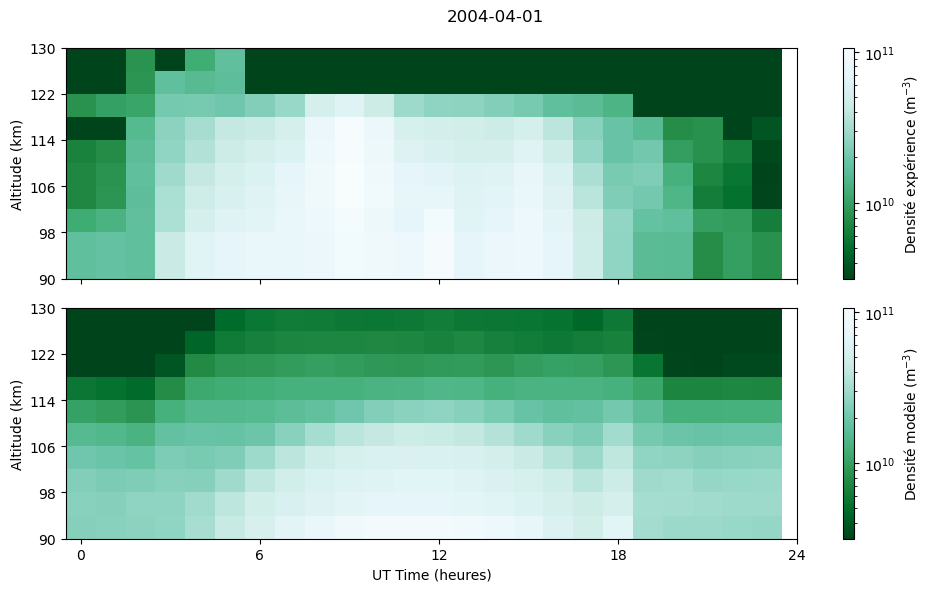

In [75]:
fig, axs = plt.subplots(2, figsize=(10, 6), sharex=True)
fig.suptitle(f'{str(date)}')

X, Y = np.meshgrid(time_bins, H_bins+2)

grid = Ne_EXP[index].reshape(len(H_bins), len(time_bins))[::-1]
norm = LogNorm(vmin=np.nanmin(grid[grid > 1]), vmax=np.nanmax(grid))
sc = axs[0].pcolormesh(X, Y, grid, cmap='BuGn_r', norm=norm)
cbar = fig.colorbar(sc, ax=axs[0])
cbar.set_label(r'Densité expérience ($\mathrm{m^{-3}}$)')

grid = Ne_WACCM[index].reshape(len(H_bins), len(time_bins))[::-1]
sc = axs[1].pcolormesh(X, Y, grid, cmap='BuGn_r', norm=norm)
cbar = fig.colorbar(sc, ax=axs[1])
cbar.set_label(r"Densité modèle ($\mathrm{m^{-3}}$)")

for ax in axs:
    ax.set_ylabel('Altitude (km)')
    ax.set_yticks(np.linspace(90,130,6))
    ax.set_ylim(90,130)

axs[-1].set_xlabel('UT Time (heures)')
axs[-1].set_xticks(np.linspace(0,24,5))

plt.tight_layout()
plt.show()

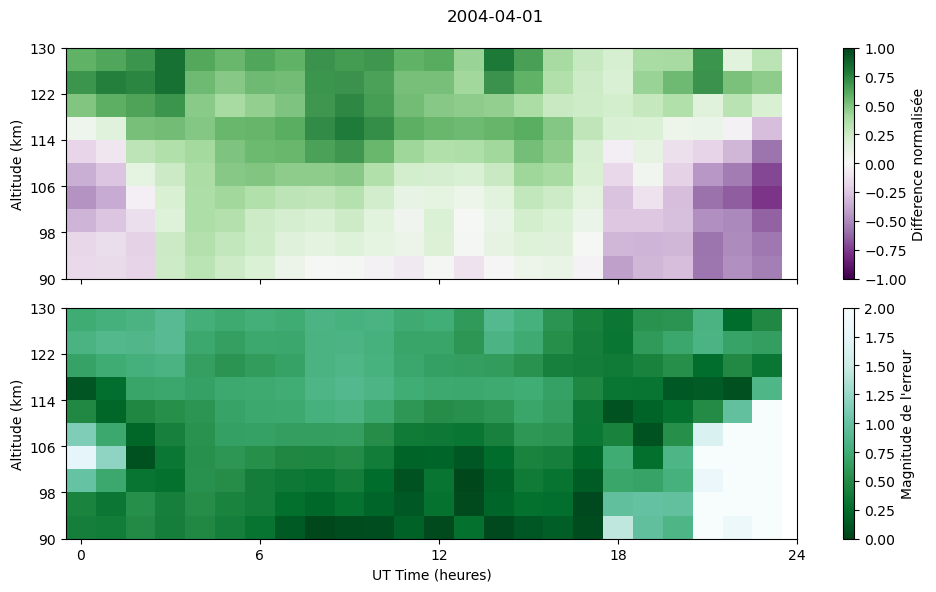

In [76]:
fig, axs = plt.subplots(2, figsize=(10, 6), sharex=True)
fig.suptitle(f'{str(date)}')

X, Y = np.meshgrid(time_bins, H_bins+2)

grid = norm_diff[index].reshape(len(H_bins), len(time_bins))[::-1]
sc = axs[0].pcolormesh(X, Y, grid, cmap='PRGn', vmin=-1, vmax=1)
cbar = fig.colorbar(sc, ax=axs[0])
cbar.set_label(r'Difference normalisée')

grid = abs_diff[index].reshape(len(H_bins), len(time_bins))[::-1]
sc = axs[1].pcolormesh(X, Y, grid, cmap='BuGn_r', vmin=0, vmax = 2)
cbar = fig.colorbar(sc, ax=axs[1])
cbar.set_label(r"Magnitude de l'erreur")

for ax in axs:
    ax.set_ylabel('Altitude (km)')
    ax.set_yticks(np.linspace(90,130,6))
    ax.set_ylim(90,130)

axs[-1].set_xlabel('UT Time (heures)')
axs[-1].set_xticks(np.linspace(0,24,5))

plt.tight_layout()
plt.show()

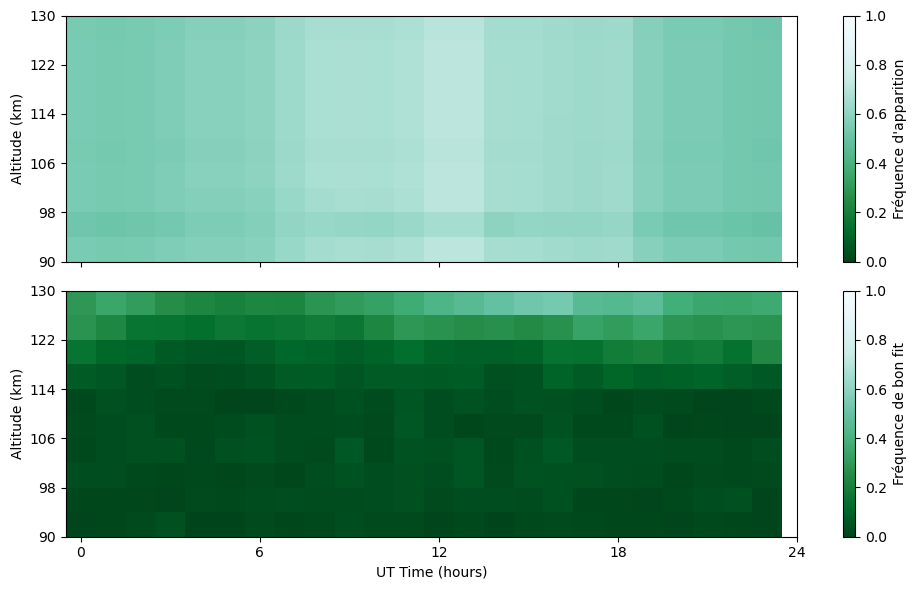

In [77]:
fig, axs = plt.subplots(2, figsize=(10, 6), sharex=True)

X, Y = np.meshgrid(time_bins, H_bins+2)

grid = count.reshape(len(H_bins), len(time_bins))[::-1]
sc = axs[0].pcolormesh(X, Y, grid, cmap='BuGn_r', vmin=0, vmax=1)
cbar = fig.colorbar(sc, ax=axs[0])
cbar.set_label(r"Fréquence d'apparition")

grid = good.reshape(len(H_bins), len(time_bins))[::-1]
sc = axs[1].pcolormesh(X, Y, grid, cmap='BuGn_r', vmin=0, vmax=1)
cbar = fig.colorbar(sc, ax=axs[1])
cbar.set_label(r'Fréquence de bon fit')

for ax in axs:
    ax.set_ylabel('Altitude (km)')
    ax.set_yticks(np.linspace(90,130,6))
    ax.set_ylim(90,130)

axs[-1].set_xlabel('UT Time (hours)')
axs[-1].set_xticks(np.linspace(0,24,5))

plt.tight_layout()
plt.show()

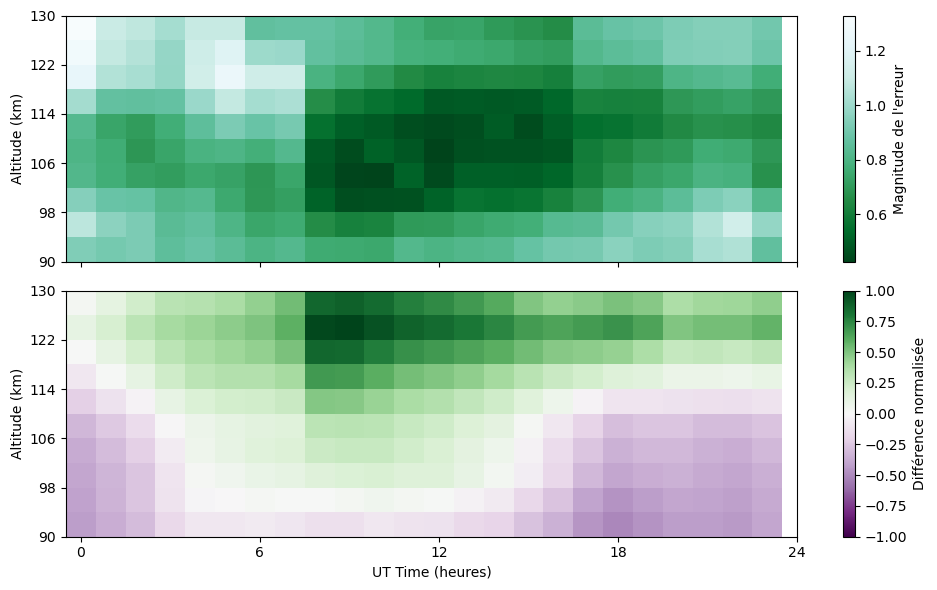

In [78]:
fig, axs = plt.subplots(2, figsize=(10, 6), sharex=True)

X, Y = np.meshgrid(time_bins, H_bins+2)

grid = err_mag_tot.reshape(len(H_bins), len(time_bins))[::-1]
sc = axs[0].pcolormesh(X, Y, grid, cmap='BuGn_r')
cbar = fig.colorbar(sc, ax=axs[0])
cbar.set_label(r"Magnitude de l'erreur")

grid = norm_diff_tot.reshape(len(H_bins), len(time_bins))[::-1]
sc = axs[1].pcolormesh(X, Y, grid, cmap='PRGn', vmin=-1, vmax=1)
cbar = fig.colorbar(sc, ax=axs[1])
cbar.set_label(r'Différence normalisée')

for ax in axs:
    ax.set_ylabel('Altitude (km)')
    ax.set_yticks(np.linspace(90,130,6))
    ax.set_ylim(90,130)

axs[-1].set_xlabel('UT Time (heures)')
axs[-1].set_xticks(np.linspace(0,24,5))

plt.tight_layout()
plt.show()
